### __Adderar nytt data för att uppdatera modellen. Nytt data från 20190820 och framåt. Plockar de i VNUM 1-3 med högst sannolikhet att vinna__

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from sklearn.model_selection import GridSearchCV 

In [3]:
# Necessary Sklearn objects used in the analysis
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

In [4]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
import sklearn.preprocessing as preproc 

In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = os.getcwd()
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR)

In [6]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [7]:
df0 = pd.read_excel('DataV75Outtake20190820.xlsx')

In [8]:
# Skapar en unik nyckel på lopp: Gör om Datum och lopp till en sträng

df0['cdate'] = df0.Datum.astype('object')
df0['cLopp'] = df0.Lopp.astype('object')

In [9]:
df0['Key'] = df0['cdate'].astype(str) + df0['cLopp'].astype(str)

__Skapar en målvariabel - vinnare__

In [10]:
df0['Y'] = np.where(df0['Plac'].isin([1]), 1,0)

__Plockar bort de variabler som inte ska med__

In [11]:
# Alla analysvariabler
df1 = df0.copy(deep = True).set_index(['Key'])


In [12]:
# Tar enbart vnum 1-3, de ska med i uttaget
df1 = df1[df1.VNUM.isin([1,2,3])]    

In [13]:
df1.head()

,Datum,Arstid,Distans,Startsatt,Lopp,Plac,Hast,V75PROC,V_ODDS,GRUPP,...,SP_R,ToR,P_R,TK_R,Ex_R,R_R,Ts_R,cdate,cLopp,Y
Key,,,,,,,,,,,,,,,,,,,,,
2016-05-21 00:00:001,2016-05-21,1,3,2,1,1,1,0.55,1.3,1,...,NaN,NaN,1.0,NaN,NaN,NaN,1,2016-05-21 00:00:00,1,1
2016-05-21 00:00:001,2016-05-21,1,3,2,1,0,7,0.09,16.6,2,...,NaN,NaN,2.0,NaN,NaN,NaN,0,2016-05-21 00:00:00,1,0
2016-05-21 00:00:001,2016-05-21,1,3,2,1,0,6,0.12,7.6,2,...,NaN,NaN,0.0,NaN,NaN,NaN,2,2016-05-21 00:00:00,1,0
2016-05-21 00:00:002,2016-05-21,1,2,1,2,1,11,0.08,8.8,2,...,NaN,NaN,0.0,NaN,NaN,NaN,3,2016-05-21 00:00:00,2,1
2016-05-21 00:00:002,2016-05-21,1,2,1,2,0,6,0.47,1.7,1,...,NaN,NaN,1.0,NaN,NaN,NaN,1,2016-05-21 00:00:00,2,0


In [14]:
df1.Distans.value_counts()

2    3307
1    1212
3    1151
Name: Distans, dtype: int64

In [15]:
df1.Startsatt.value_counts()

1    4187
2    1483
Name: Startsatt, dtype: int64

__Plockar bort de variabler som inte ska med__

In [157]:
# Alla analysvariabler
df1 = df1.drop(['Plac','cdate','cLopp','TK_R','Arstid','Startsatt', 'VNUM', 'GRUPP', 'Distans',
               'cLopp','cdate','V75PROC', 'V_ODDS',  'SP_R','E_R'], axis = 1)

In [158]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5670 entries, 2016-05-21 00:00:001 to 2019-08-14 00:00:007
Data columns (total 26 columns):
Datum          5670 non-null datetime64[ns]
Lopp           5670 non-null int64
Hast           5670 non-null int64
VLP            5670 non-null float64
SVLP           5670 non-null float64
VSVLP          5670 non-null float64
VPN_SUM        5670 non-null float64
VPN_SUM_ORD    5670 non-null int64
VPK_SUM        5670 non-null float64
VPK_SUM_ORD    5670 non-null float64
VLPB           5670 non-null float64
SVLPB          5670 non-null float64
VSVLPB         5670 non-null float64
E_P            5670 non-null float64
E_P_Num        5670 non-null int64
E_N            5670 non-null float64
E_U            5397 non-null float64
G_R            5187 non-null float64
A_R            4809 non-null float64
T_R            5229 non-null float64
ToR            4914 non-null float64
P_R            5040 non-null float64
Ex_R           3486 non-null float64
R_R          

In [159]:
num_attribs = [] 
cat_attribs = [] 

for var, typ in zip(df1.columns[:-1], df1.dtypes[:-1]): 
    if typ == 'object': 
        cat_attribs.append(var) 
    elif (typ != 'datetime64[ns]')  & (var != 'Hast') & (var != 'Lopp'): 
        num_attribs.append(var)

In [160]:
cat_attribs 

[]

In [161]:
num_attribs 

['VLP',
 'SVLP',
 'VSVLP',
 'VPN_SUM',
 'VPN_SUM_ORD',
 'VPK_SUM',
 'VPK_SUM_ORD',
 'VLPB',
 'SVLPB',
 'VSVLPB',
 'E_P',
 'E_P_Num',
 'E_N',
 'E_U',
 'G_R',
 'A_R',
 'T_R',
 'ToR',
 'P_R',
 'Ex_R',
 'R_R',
 'Ts_R']

__Nu bygger vi upp en pipeline__

In [162]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
# Denna klass måste vi göra för att särskilja numeriska variabler mot character variabler
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Egen klass för att sätta dummyvariabler

class SetDummyVar(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        tempdf = pd.get_dummies(X[self.attribute_names], columns = self.attribute_names)
        return tempdf.values

# Pipeline för numeriska variabler
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median"))
    ])

cat_pipeline = Pipeline([
        ('dummy_cat', SetDummyVar(cat_attribs)),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
    ])

/Users/ulf/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [163]:
df2 = df1.copy(deep = True)    

In [164]:
len(df2)

5670

In [165]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5670 entries, 2016-05-21 00:00:001 to 2019-08-14 00:00:007
Data columns (total 26 columns):
Datum          5670 non-null datetime64[ns]
Lopp           5670 non-null int64
Hast           5670 non-null int64
VLP            5670 non-null float64
SVLP           5670 non-null float64
VSVLP          5670 non-null float64
VPN_SUM        5670 non-null float64
VPN_SUM_ORD    5670 non-null int64
VPK_SUM        5670 non-null float64
VPK_SUM_ORD    5670 non-null float64
VLPB           5670 non-null float64
SVLPB          5670 non-null float64
VSVLPB         5670 non-null float64
E_P            5670 non-null float64
E_P_Num        5670 non-null int64
E_N            5670 non-null float64
E_U            5397 non-null float64
G_R            5187 non-null float64
A_R            4809 non-null float64
T_R            5229 non-null float64
ToR            4914 non-null float64
P_R            5040 non-null float64
Ex_R           3486 non-null float64
R_R          

In [166]:
# Skapar en lista med de unika omgångarna

dates = df2.Datum

In [167]:
date_list = list(set(dates.to_list()))

In [168]:
date_dict = {'Date':date_list}

In [169]:
date_frame = pd.DataFrame(date_dict)

In [170]:
len(date_frame)

270

__Delar upp datat i två mängder. En för att bygga modell och en för validering__

In [171]:
# Plockar ut 80 stycken datum slumpmässigt som ska användas för validering

test_list = date_frame.sample(n = 80, random_state = 42).Date.to_list()

In [172]:
test, basedf = df2[df2.Datum.isin(test_list)], df2[~df2.Datum.isin(test_list)]

In [173]:
basedf.Y.sum()

906

In [174]:
test.Y.sum()

406

__Bygger modellen - Logistik regression__

In [175]:

features_base = full_pipeline.fit_transform(basedf)
## En array som håller det vi vill predikter
label_base = basedf["Y"].copy()

In [176]:
features_test = full_pipeline.fit_transform(test)
## En array som håller det vi vill predikter
label_test = test["Y"].copy()

In [177]:
from sklearn.linear_model import LogisticRegression

In [178]:
log_clf= LogisticRegression(solver="liblinear", C = 0.1, random_state=42)

# Utvärderar styrkan i modellen - sätter hyperparametrarna och cross fold fem
scores_base = cross_val_score(log_clf, features_base,label_base, scoring = "roc_auc", cv = 5 ) 

scores_base

array([0.63828878, 0.58750683, 0.63207285, 0.60850488, 0.603636  ])

In [179]:
scores_base.mean()

0.614001869572175

## Bygger modellen-validerar på undanlagt testdata

In [180]:
model_base = log_clf.fit(features_base,label_base)
log_clf.fit(features_base,label_base)
predict19 = log_clf.predict_proba(features_test)

fpr, tpr, threshold = roc_curve(label_test,predict19[:,1])
roc_auc = auc(fpr,tpr)
print(roc_auc)

0.6272242887302704


In [181]:
c_list_19 = model_base.coef_.tolist()

import math

for var,par in zip(num_attribs, c_list_19[0]):
    OddsRatio = math.exp(float(par))
    print(var +':', str(round(par,3)) + ':', round(OddsRatio,2))

VLP: 0.002: 1.0
SVLP: -0.0: 1.0
VSVLP: 0.061: 1.06
VPN_SUM: 0.249: 1.28
VPN_SUM_ORD: -0.029: 0.97
VPK_SUM: 0.098: 1.1
VPK_SUM_ORD: -0.051: 0.95
VLPB: 0.002: 1.0
SVLPB: 0.006: 1.01
VSVLPB: -0.005: 1.0
E_P: -0.033: 0.97
E_P_Num: -0.039: 0.96
E_N: 0.007: 1.01
E_U: -0.035: 0.97
G_R: 0.09: 1.09
A_R: -0.006: 0.99
T_R: -0.048: 0.95
ToR: -0.056: 0.95
P_R: 0.046: 1.05
Ex_R: -0.143: 0.87
R_R: -0.06: 0.94
Ts_R: -0.105: 0.9


In [75]:
from sklearn.externals import joblib

#Pipelineobjekt
joblib.dump(full_pipeline, 'Pipeline_top1.pkl')

# Modellobjekt
joblib.dump(model_base, 'Travmodel_top1.pkl')

['Travmodel_top1.pkl']

__Applicerar modellen på alla de omgångar som är undanstoppade. För varje lopp i omgången plockar vi de tre högst scorade. Sedan ser vi hur många rätt som vi får per omgång__

In [186]:
val_df = df2[df2.Datum.isin(test_list)]

In [221]:
pdf = omgdf.Y.to_frame().reset_index()

In [222]:
pdf

,Key,Y
0,2018-01-27 00:00:001,1
1,2018-01-27 00:00:001,0
2,2018-01-27 00:00:001,0
3,2018-01-27 00:00:002,1
4,2018-01-27 00:00:002,0
5,2018-01-27 00:00:002,0
6,2018-01-27 00:00:003,1
7,2018-01-27 00:00:003,0
8,2018-01-27 00:00:003,0
9,2018-01-27 00:00:004,1


In [330]:
df_list = []
#score_list = []
#plac_list = []
i = 0
for date in test_list:
    omgdf = val_df[val_df.Datum == date]
    nullcheck = omgdf[num_attribs].isnull().sum(axis = 0).sum()
    if nullcheck < 10:
        omg_features = full_pipeline.fit_transform(omgdf) 
        predict19 = log_clf.predict_proba(omg_features)
        sdf = pd.DataFrame({'Prob1':predict19[:,1], 'Date': date})
        pdf = omgdf.Y.to_frame().reset_index()
        adf = sdf.merge(pdf['Y'], left_index = True, right_index = True).sort_values('Prob1', ascending = False)
        qdf = pd.qcut(adf.Prob1,21, labels=["1", "2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21"]).to_frame().rename(columns = {'Prob1':'Bin'})
        # Lägger på indelningen
        adf = adf.merge(qdf, left_index = True, right_index = True)
        if i == 0:
            analys_df = adf
        else:
            analys_df = pd.concat([analys_df, adf], axis = 0)
        i = i + 1
        
        
    

In [331]:
analys_df

,Prob1,Date,Y,Bin
6,0.538943,2018-01-27,1,21
8,0.414541,2018-01-27,0,20
1,0.350930,2018-01-27,0,19
2,0.341215,2018-01-27,0,18
20,0.313872,2018-01-27,0,17
9,0.282623,2018-01-27,1,16
15,0.276128,2018-01-27,1,15
13,0.227445,2018-01-27,0,14
11,0.205003,2018-01-27,0,13
0,0.175634,2018-01-27,1,12


In [332]:
descrip = analys_df.groupby(['Date','Bin'])['Y'].sum().to_frame()
descrip

Y
Date       Bin   
2017-07-22 1    0
           2    0
           3    0
           4    0
           5    1
           6    0
           7    0
           8    0
           9    0
           10   0
           11   0
           12   0
           13   0
           14   0
           15   1
           16   0
           17   0
           18   0
           19   0
           20   1
           21   1
2017-08-19 1    0
           2    0
           3    0
           4    0
           5    0
           6    0
           7    0
           8    0
           9    0
...            ..
2019-07-30 13   0
           14   0
           15   0
           16   1
           17   0
           18   0
           19   0
           20   0
           21   1
2019-08-03 1    1
           2    0
           3    0
           4    0
           5    0
           6    0
           7    0
           8    1
           9    0
           10   0
           11   0
           12   1
           13   0
           14   0
           15   0
           16   0
           17   0
           18   1
           19   0
           20   0
           21   1

[840 rows x 1 columns]

In [296]:
descrip1 = descrip.reset_index()
descrip1[descrip1.Bin == 'Q3'].median()

Y    3.0
dtype: float64

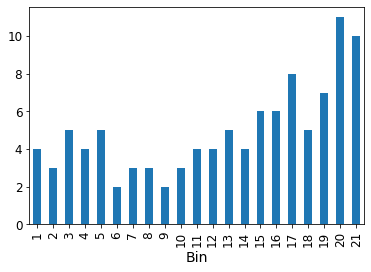

In [333]:
round(analys_df.groupby('Bin')['Y'].sum()/analys_df.Y.sum()*100).plot('bar')

In [329]:
analys_df.to_excel('top21_analys.xlsx', index = False)